Train: https://www.kaggle.com/crowdflower/twitter-airline-sentiment
Evaluate: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews


Tutorial base. Basicamente voy a analizar sentimientos en diferente contexto
https://www.kaggle.com/lykin22/twitter-sentiment-analysis-with-naive-bayes-85-acc


In [195]:
import pandas as pd
import numpy as np
import matplotlib as nlp
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from math import *
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

import re

In [196]:
airline_tweets = pd.read_csv('https://raw.githubusercontent.com/Jaleab/sentiment-analysis/main/Tweets.csv')
movie_reviews = pd.read_csv('https://raw.githubusercontent.com/Jaleab/sentiment-analysis/main/IMDB%20Dataset.csv')


**EDA**

In [197]:
airline_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [198]:
airline_tweets.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [199]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [200]:
movie_reviews.columns

Index(['review', 'sentiment'], dtype='object')

**Revision de nulos**

In [201]:
airline_tweets.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [202]:
movie_reviews.isnull().sum()

review       0
sentiment    0
dtype: int64

Limpieza de columnas innecesarias

In [203]:
airline_tweets = airline_tweets.drop(["tweet_coord", "user_timezone", "tweet_location", "name","airline_sentiment_gold","retweet_count","tweet_created"], axis=1)
airline_tweets = airline_tweets.drop(["tweet_id", "airline", "negativereason_gold", "airline_sentiment_confidence", "negativereason_confidence"], axis=1)
airline_tweets = airline_tweets.drop(["negativereason"], axis=1)


In [204]:
airline_tweets.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [205]:
airline_tweets.airline_sentiment.value_counts()


negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [206]:
airline_tweets = airline_tweets[airline_tweets.airline_sentiment != 'neutral' ]
airline_tweets.airline_sentiment.value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [207]:
# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) 
#that a search engine has been programmed to ignore,
#both when indexing entries for searching and when retrieving them as the result of a search query.
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
print(stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'been', "couldn't", 'your', 'that', 'out', 'during', 'herself', 'were', 'too', 'such', 'why', 'in', 'hasn', 've', 'yourselves', 'into', 'more', "needn't", 'now', 'few', 'down', 'these', 'their', 'very', 'how', "mustn't", "didn't", 'had', 'has', 'who', 'at', "don't", 'his', 'shouldn', 'we', 'what', 'himself', 'off', 'haven', "shan't", 'any', "you're", 'some', 'only', 'where', 'our', 'i', 'below', "that'll", 'not', 'between', "shouldn't", 'with', 'than', 'don', 'both', 't', 'further', 'hers', 'other', "isn't", "won't", 'it', 'do', 'being', "haven't", 'mightn', 'and', 'up', 'couldn', "wasn't", 'its', 'will', "hadn't", 'aren', 'theirs', 'won', 'again', 'when', 'nor', 'most', 'was', 'can', 'll', 'ain', "wouldn't", 'a', 're', 'ourselves', 'this', 'themselves', 'be', 'having', 'my', "doesn't", 'to', 'm', 'from', "you've", 'they', 'all', 'then', 'before', 'over', "mightn't", 

In [208]:
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
some = 'amp,today,tomorrow,going,girl'
def process_text(text):
  # Lower Casing
    text = re.sub(r"he's", "he is", text )
    text = re.sub(r"there's", "there is", text )
    text = re.sub(r"We're", "We are", text )
    text = re.sub(r"That's", "That is", text )
    text = re.sub(r"won't", "will not", text )
    text = re.sub(r"they're", "they are", text )
    text = re.sub(r"Can't", "Cannot", text )
    text = re.sub(r"wasn't", "was not", text )
    text = re.sub(r"don\x89Ûªt", "do not", text )
    text = re.sub(r"aren't", "are not", text )
    text = re.sub(r"isn't", "is not", text )
    text = re.sub(r"What's", "What is", text )
    text = re.sub(r"haven't", "have not", text )
    text = re.sub(r"hasn't", "has not", text )
    text = re.sub(r"There's", "There is", text )
    text = re.sub(r"He's", "He is", text )
    text = re.sub(r"It's", "It is", text )
    text = re.sub(r"You're", "You are", text )
    text = re.sub(r"I'M", "I am", text )
    text = re.sub(r"shouldn't", "should not", text )
    text = re.sub(r"wouldn't", "would not", text )
    text = re.sub(r"i'm", "I am", text )
    text = re.sub(r"I\x89Ûªm", "I am", text )
    text = re.sub(r"I'm", "I am", text )
    text = re.sub(r"Isn't", "is not", text )
    text = re.sub(r"Here's", "Here is", text )
    text = re.sub(r"you've", "you have", text )
    text = re.sub(r"you\x89Ûªve", "you have", text )
    text = re.sub(r"we're", "we are", text )
    text = re.sub(r"what's", "what is", text )
    text = re.sub(r"couldn't", "could not", text )
    text = re.sub(r"we've", "we have", text )
    text = re.sub(r"it\x89Ûªs", "it is", text )
    text = re.sub(r"doesn\x89Ûªt", "does not", text )
    text = re.sub(r"It\x89Ûªs", "It is", text )
    text = re.sub(r"Here\x89Ûªs", "Here is", text )
    text = re.sub(r"who's", "who is", text )
    text = re.sub(r"I\x89Ûªve", "I have", text )
    text = re.sub(r"y'all", "you all", text )
    text = re.sub(r"can\x89Ûªt", "cannot", text )
    text = re.sub(r"would've", "would have", text )
    text = re.sub(r"it'll", "it will", text )
    text = re.sub(r"we'll", "we will", text )
    text = re.sub(r"wouldn\x89Ûªt", "would not", text )
    text = re.sub(r"We've", "We have", text )
    text = re.sub(r"he'll", "he will", text )
    text = re.sub(r"Y'all", "You all", text )
    text = re.sub(r"Weren't", "Were not", text )
    text = re.sub(r"Didn't", "Did not", text )
    text = re.sub(r"they'll", "they will", text )
    text = re.sub(r"they'd", "they would", text )
    text = re.sub(r"DON'T", "DO NOT", text )
    text = re.sub(r"That\x89Ûªs", "That is", text )
    text = re.sub(r"they've", "they have", text )
    text = re.sub(r"i'd", "I would", text )
    text = re.sub(r"should've", "should have", text )
    text = re.sub(r"You\x89Ûªre", "You are", text )
    text = re.sub(r"where's", "where is", text )
    text = re.sub(r"Don\x89Ûªt", "Do not", text )
    text = re.sub(r"we'd", "we would", text )
    text = re.sub(r"i'll", "I will", text )
    text = re.sub(r"weren't", "were not", text )
    text = re.sub(r"They're", "They are", text )
    text = re.sub(r"Can\x89Ûªt", "Cannot", text )
    text = re.sub(r"you\x89Ûªll", "you will", text )
    text = re.sub(r"I\x89Ûªd", "I would", text )
    text = re.sub(r"let's", "let us", text )
    text = re.sub(r"it's", "it is", text )
    text = re.sub(r"can't", "cannot", text )
    text = re.sub(r"don't", "do not", text )
    text = re.sub(r"you're", "you are", text )
    text = re.sub(r"i've", "I have", text )
    text = re.sub(r"that's", "that is", text )
    text = re.sub(r"i'll", "I will", text )
    text = re.sub(r"doesn't", "does not", text )
    text = re.sub(r"i'd", "I would", text )
    text = re.sub(r"didn't", "did not", text )
    text = re.sub(r"ain't", "am not", text )
    text = re.sub(r"you'll", "you will", text )
    text = re.sub(r"I've", "I have", text )
    text = re.sub(r"Don't", "do not", text )
    text = re.sub(r"I'll", "I will", text )
    text = re.sub(r"I'd", "I would", text )
    text = re.sub(r"Let's", "Let us", text )
    text = re.sub(r"you'd", "You would", text )
    text = re.sub(r"It's", "It is", text )
    text = re.sub(r"Ain't", "am not", text )
    text = re.sub(r"Haven't", "Have not", text )
    text = re.sub(r"Could've", "Could have", text )
    text = re.sub(r"youve", "you have", text )  
    text = re.sub(r"donå«t", "do not", text )  
    
    text = re.sub(r"some1", "someone", text )
    text = re.sub(r"yrs", "years", text )
    text = re.sub(r"hrs", "hours", text )
    text = re.sub(r"2morow|2moro", "tomorrow", text )
    text = re.sub(r"2day", "today", text )
    text = re.sub(r"4got|4gotten", "forget", text )
    text = re.sub(r"b-day|bday", "b-day", text )
    text = re.sub(r"mother's", "mother", text )
    text = re.sub(r"mom's", "mom", text )
    text = re.sub(r"dad's", "dad", text )
    text = re.sub(r"hahah|hahaha|hahahaha", "haha", text )
    text = re.sub(r"lmao|lolz|rofl", "lol", text )
    text = re.sub(r"thanx|thnx", "thanks", text )
    text = re.sub(r"goood", "good", text )
    text = re.sub(r"some1", "someone", text )
    text = re.sub(r"some1", "someone", text )
    text = text.lower()
    text = text[1:]
    # Removing all URls 
    text = re.sub(urlPattern,'',text)
    # Removing all @username.
    text = re.sub(userPattern,'', text ) 
    #remove some words
    text = re.sub(some,'',text)
    #Remove punctuations
    text = text.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(text)
    #tokens = [w for w in tokens if len(w)>2]
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [209]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [210]:
def convert_abbrev_in_text(text):
    t = []
    words = text.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t)  

In [211]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [216]:
# Airline tweets
airline_tweets['processed_text'] = airline_tweets['text'].apply(lambda x: process_text(x))
airline_tweets['processed_text'] = airline_tweets['processed_text'].apply(lambda x: convert_abbrev_in_text(x))
print('Text Preprocessing complete.')
airline_tweets.head(5)

Text Preprocessing complete.


,airline_sentiment,text,processed_text
1,positive,@VirginAmerica plus you've added commercials t...,virginamerica plus added commercial experience...
3,negative,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...
4,negative,@VirginAmerica and it's a really big bad thing...,virginamerica really big bad thing
5,negative,@VirginAmerica seriously would pay $30 a fligh...,virginamerica seriously would pay 30 flight se...
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",virginamerica yes nearly every time fly vx ear...


In [217]:
#removing shortwords
airline_tweets['processed_text'] = airline_tweets['processed_text'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
airline_tweets.head(5)

,airline_sentiment,text,processed_text
1,positive,@VirginAmerica plus you've added commercials t...,virginamerica plus added commercial experience...
3,negative,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...
4,negative,@VirginAmerica and it's a really big bad thing...,virginamerica really thing
5,negative,@VirginAmerica seriously would pay $30 a fligh...,virginamerica seriously would flight seat play...
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",virginamerica nearly every time worm away


In [218]:
# Movie reviews
movie_reviews['processed_review'] = movie_reviews['review'].apply(lambda x: process_text(x))
movie_reviews['processed_review'] = movie_reviews['processed_review'].apply(lambda x: convert_abbrev_in_text(x))
print('Text Preprocessing complete.')
airline_tweets.head(5)

Text Preprocessing complete.


,airline_sentiment,text,processed_text
1,positive,@VirginAmerica plus you've added commercials t...,virginamerica plus added commercial experience...
3,negative,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...
4,negative,@VirginAmerica and it's a really big bad thing...,virginamerica really thing
5,negative,@VirginAmerica seriously would pay $30 a fligh...,virginamerica seriously would flight seat play...
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",virginamerica nearly every time worm away


In [219]:
#removing shortwords
movie_reviews['processed_review'] = movie_reviews['processed_review'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
movie_reviews.head(5)

,review,sentiment,processed_review
0,One of the other reviewers has mentioned that ...,positive,reviewer mentioned watching episode hooked rig...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful spend time summer weekend si...
3,Basically there's a family where a little boy ...,negative,asically family little jake think zombie close...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,etter matteis love time money visually stunnin...


In [220]:
from sklearn.utils import shuffle
airline_tweets = shuffle(airline_tweets).reset_index(drop=True)
movie_reviews = shuffle(movie_reviews).reset_index(drop=True)

### Tokenization

In [221]:
tokenized_tweet_negative = (airline_tweets[airline_tweets.airline_sentiment == 'negative' ])['processed_text'].apply(lambda x: x.split())
tokenized_tweet_positive = (airline_tweets[airline_tweets.airline_sentiment == 'positive' ])['processed_text'].apply(lambda x: x.split())

tokenized_review_negative = (movie_reviews[movie_reviews.sentiment == 'negative' ])['processed_review'].apply(lambda x: x.split())
tokenized_review_positive = (movie_reviews[movie_reviews.sentiment == 'positive' ])['processed_review'].apply(lambda x: x.split())

In [222]:
from nltk import FreqDist, classify, NaiveBayesClassifier
import re, string, random
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

def get_texts_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

def get_dataset_for_model(tokenized_tweet_positive, tokenized_tweet_negative):
  positive_tokens_for_model = get_texts_for_model(tokenized_tweet_positive)
  negative_tokens_for_model = get_texts_for_model(tokenized_tweet_negative)

  positive_dataset = [(tweet_dict, "Positive")
                          for tweet_dict in positive_tokens_for_model]

  negative_dataset = [(tweet_dict, "Negative")
                      for tweet_dict in negative_tokens_for_model]

  dataset = positive_dataset + negative_dataset
  random.shuffle(dataset)
  return dataset


In [223]:
# Palabras más frecuentes en los tweets positivos
all_pos_words = get_all_words(tokenized_tweet_positive)
freq_dist_pos = FreqDist(all_pos_words)
print(freq_dist_pos.most_common(10))

[('thanks', 611), ('southwestair', 557), ('jetblue', 539), ('united', 502), ('thank', 492), ('flight', 432), ('americanair', 323), ('usairways', 265), ('great', 234), ('service', 161)]


In [224]:
# Palabras más frecuentes en los tweets negativos
all_pos_words = get_all_words(tokenized_tweet_negative)
freq_dist_pos = FreqDist(all_pos_words)
print(freq_dist_pos.most_common(10))

[('flight', 3319), ('united', 2762), ('usairways', 2268), ('americanair', 1917), ('hour', 1362), ('southwestair', 1173), ('jetblue', 977), ('cancelled', 920), ('customer', 773), ('service', 761)]


In [225]:
# Palabras más frecuentes en los reviews positivos
all_pos_words = get_all_words(tokenized_review_positive)
freq_dist_pos = FreqDist(all_pos_words)
print(freq_dist_pos.most_common(10))

[('film', 47856), ('movie', 43105), ('like', 17561), ('time', 15219), ('good', 14426), ('story', 13652), ('character', 13637), ('great', 12725), ('would', 12710), ('well', 10999)]


In [226]:
# Palabras más frecuentes en los reviews negativos
all_pos_words = get_all_words(tokenized_review_negative)
freq_dist_pos = FreqDist(all_pos_words)
print(freq_dist_pos.most_common(10))

[('movie', 55836), ('film', 41867), ('like', 22260), ('would', 17275), ('even', 15040), ('time', 14224), ('good', 14206), ('character', 13961), ('make', 12586), ('really', 12227)]


In [232]:
train_tweets = get_dataset_for_model(tokenized_tweet_positive, tokenized_tweet_negative)
test_reviews = get_dataset_for_model(tokenized_review_positive, tokenized_review_negative)

classifier = NaiveBayesClassifier.train(train_tweets)

tweets_accuracy = classify.accuracy(classifier, train_tweets)
reviews_accuracy = classify.accuracy(classifier, test_reviews)
print(classifier.show_most_informative_features(10))

Most Informative Features
                passbook = True           Positi : Negati =     40.1 : 1.0
                favorite = True           Positi : Negati =     37.5 : 1.0
             outstanding = True           Positi : Negati =     32.4 : 1.0
               fantastic = True           Positi : Negati =     30.3 : 1.0
                   raise = True           Positi : Negati =     29.8 : 1.0
               beautiful = True           Positi : Negati =     29.8 : 1.0
                   kudos = True           Positi : Negati =     28.3 : 1.0
                  online = True           Negati : Positi =     26.4 : 1.0
                 awesome = True           Positi : Negati =     21.4 : 1.0
               wonderful = True           Positi : Negati =     21.1 : 1.0
None


### Naive Bayes

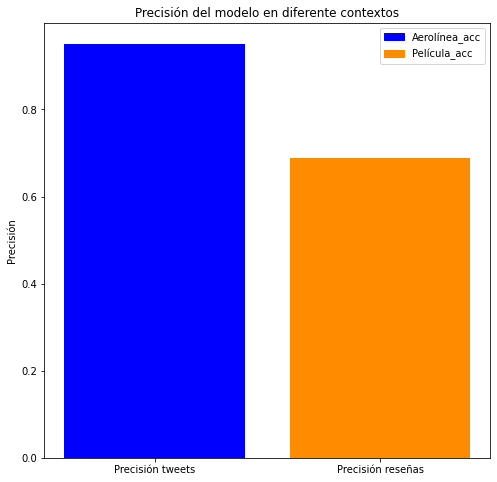

Precisión tweets aerolínea:  0.9512173988389221
Precisión reseñas películas:  0.68912


In [236]:
#plotting the best parameters
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
data_classifier = [tweets_accuracy, reviews_accuracy]
labels = ['Precisión tweets', 'Precisión reseñas']
plt.xticks(range(len(data_classifier)), labels)
plt.ylabel('Precisión')
plt.title('Precisión del modelo en diferente contextos')
plt.bar(range(len(data_classifier)), data_classifier,color=['blue','darkorange']) 
Train_acc = mpatches.Patch(color='blue', label='Aerolínea_acc')
Test_acc = mpatches.Patch(color='darkorange', label='Película_acc')
plt.legend(handles=[Train_acc, Test_acc],loc='best')
plt.gcf().set_size_inches(8, 8)
plt.show()
print("Precisión tweets aerolínea: ", tweets_accuracy)
print("Precisión reseñas películas: ", reviews_accuracy)